# PAE Tutorial

### step-by-step instructions for training a probabilsitic autoencoder with this package

In [1]:
# import this package 
from pytorch_pae import AE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# import pytorch
import torch

print(torch.__version__)

1.8.0


In [4]:
from torchsummary import summary

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Step 1: Choose your parameters

In [28]:
## data parameters
dataset       = 'MNIST'
loc           = '/global/cscratch1/sd/vboehm/Datasets'

# number of layers in networks
n_layers     = 3

## convolutional net specific parameters
# number of channels in each layer for convolutional neural net
out_channels = [16,16,16]
# kernel sizes in each layer for conv net
kernel_sizes = [9,2,6]
# scaling factor in max pooling layer 
scale_facs   = [1,1,1] 
# padding values in each conv layer
paddings     = [5,2,5]
# stride values in each conv layer
strides      = [2,1,1]
# whether tp apply a layer normalization after conv layer
layer_norm   = [True,True,True]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False

## fully connected net specific parameters
# output size of each fully connected layer
out_sizes    = [256,128,64]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.4,0.4,0.8]
# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = True
# activation function after each layer
activations  = ['ReLU', 'ReLU','ReLU']
# whether to add a bias in each layer or not
bias         = [True, True, True]

## general parameters
# data dimensionality
dim          = '2D'
# latent space dimensionality
latent_dim   = 8
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 28
# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'conv'
decoder_type = 'conv'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = True


## Training parameters
nepochs       = 40
batchsize     = 64
initial_lr    = 1e-2

optimizer     = 'Adam'
criterion     = 'MSELoss'

scheduler     = 'ExponentialLR'
scheduler_params = {'gamma':0.95}



In [29]:
general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type, 'decoder_type': decoder_type, 'dim': dim}
conv_network_params = {'n_layers': n_layers, 'out_channels': out_channels, 'kernel_sizes': kernel_sizes, 'scale_facs': scale_facs, 'paddings': paddings,\
                       'strides': strides,'activations': activations, 'spec_norm': spec_norm, 'layer_norm': layer_norm,\
                       'affine': affine,'final_sigmoid': final_sigmoid, 'bias':bias}
fc_network_params   = {'n_layers': n_layers, 'out_sizes': out_sizes,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, \
                       'layer_norm': layer_norm, 'affine': affine, 'final_sigmoid': final_sigmoid, 'bias':bias}

training_params     = {'batchsize': batchsize, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion': criterion, \
                       'scheduler': scheduler, 'scheduler_params':scheduler_params}
data_params         = {'dataset':dataset, 'loc': loc}

## Step 2: Set up and train the autoencoder

In [30]:
AE1 = AE.Autoencoder(general_params,data_params,conv_network_params, conv_network_params, training_params, device)

In [31]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 15, 15]           1,312
         LayerNorm-2           [-1, 16, 15, 15]               0
              ReLU-3           [-1, 16, 15, 15]               0
 AdaptiveMaxPool2d-4           [-1, 16, 15, 15]               0
            Conv2d-5           [-1, 16, 18, 18]           1,040
         LayerNorm-6           [-1, 16, 18, 18]               0
              ReLU-7           [-1, 16, 18, 18]               0
 AdaptiveMaxPool2d-8           [-1, 16, 18, 18]               0
            Conv2d-9           [-1, 16, 23, 23]           9,232
        LayerNorm-10           [-1, 16, 23, 23]               0
             ReLU-11           [-1, 16, 23, 23]               0
AdaptiveMaxPool2d-12           [-1, 16, 23, 23]               0
          Flatten-13                 [-1, 8464]               0
           Linear-14                   

In [32]:
train_loss, valid_loss = AE1.train(nepochs)

epoch: 0, training loss: 3.5144e-02, validation loss: 2.0040e-02, learning rate: 9.5000e-03
epoch: 1, training loss: 1.9507e-02, validation loss: 1.8881e-02, learning rate: 9.0250e-03
epoch: 2, training loss: 1.7816e-02, validation loss: 1.8165e-02, learning rate: 8.5737e-03
epoch: 3, training loss: 1.6979e-02, validation loss: 1.8078e-02, learning rate: 8.1451e-03
epoch: 4, training loss: 1.6414e-02, validation loss: 1.5694e-02, learning rate: 7.7378e-03
epoch: 5, training loss: 1.6016e-02, validation loss: 1.5955e-02, learning rate: 7.3509e-03
epoch: 6, training loss: 1.5677e-02, validation loss: 1.4204e-02, learning rate: 6.9834e-03
epoch: 7, training loss: 1.5422e-02, validation loss: 1.4909e-02, learning rate: 6.6342e-03
epoch: 8, training loss: 1.5171e-02, validation loss: 1.4697e-02, learning rate: 6.3025e-03
epoch: 9, training loss: 1.4968e-02, validation loss: 1.4347e-02, learning rate: 5.9874e-03
epoch: 10, training loss: 1.4789e-02, validation loss: 1.4615e-02, learning rate

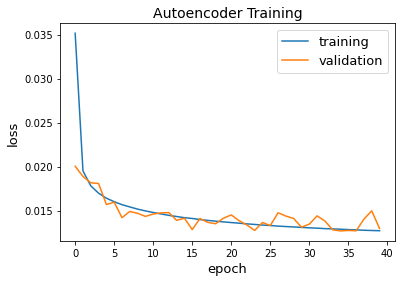

In [33]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.show()

## Data reconstructions

In [34]:
from pytorch_pae.data_loader import *

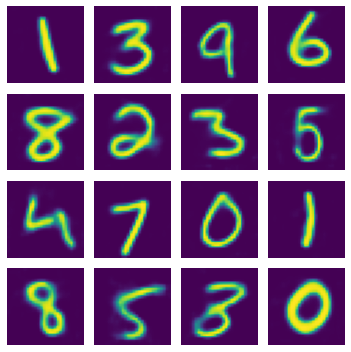

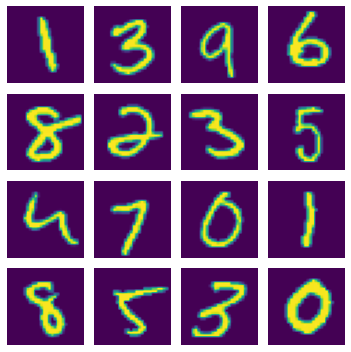

In [35]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],16)

data, _  = next(iter(train_loader))

recon = AE1.forward(data.to(device))

fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(recon[ii].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(data[ii].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()


In [36]:
torch.save(AE1, os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE'))

## Step 3: Train the density estimator on the encoded data

In [37]:
# import density estimation module
from sinf import GIS

In [38]:
# load auutoencoder
AE1 = torch.load(os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE'))

In [39]:
from pytorch_pae.data_loader import *

In [40]:
# encode data

train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],-1, -1)

data, _  = next(iter(train_loader))
data     = data.to(device)

valid_data, _  = next(iter(valid_loader))
valid_data     = valid_data.to(device)

with torch.no_grad():
    encoded_train = AE1.encoder.forward(data)
    encoded_valid = AE1.encoder.forward(valid_data)

In [41]:
# train density estimator
gis = GIS.GIS(encoded_train, data_validate=encoded_valid, verbose=False)

In [42]:
torch.save(gis, os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'GIS'))

## Density Estimation and Outlier Detection

In [43]:
logps       = gis.evaluate_density(encoded_train)
logps_valid = gis.evaluate_density(encoded_valid)

In [44]:
logps       = logps.cpu().detach().numpy()
logps_valid = logps_valid.cpu().detach().numpy()

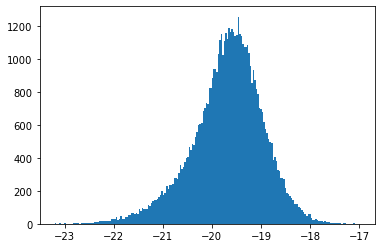

In [45]:
_       = plt.hist(logps,bins=200)

In [46]:
ranking = np.argsort(logps)

### Digits with lowest probability

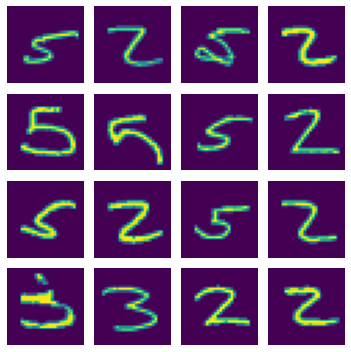

In [47]:
fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(data[ranking[ii]].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()

## Data Generation

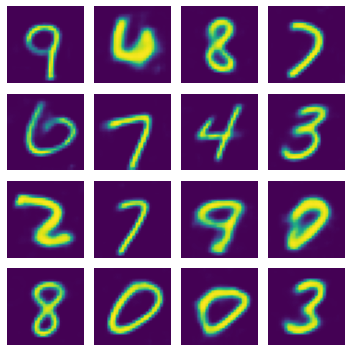

In [48]:
samples, _ = gis.sample(16)
with torch.no_grad():
    decoded_samples = AE1.decoder.forward(samples)

fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(decoded_samples[ii].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()
